### Goal 
We want to compare our results from using the tabular data to using images. The idea is that if by any chance we get comparable results to the actual data this would be an insane accomplishment since we are technically losing precision when mapping from exact coordinates to images. 

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import warnings
from PIL import Image
import io
warnings.filterwarnings("ignore")
import matplotlib
import gc

### Visulizing One Play
We need a way to visualize a play. The goal is to be visualize the entire 40 seconds unil the snap. This will be the function that we use to produce the images and process them as a video.

In [61]:
# import all the data we need to run
# start with week 1
week_1 = pd.read_csv("../Data/tracking_week_9.csv")
game_data = pd.read_csv("../Data/games.csv")
play_data = pd.read_csv("../Data/plays.csv")

In [23]:
# next step. rescale the image to be less size
# check the memory for creating a random tensor of the same size
# the pickle file is huge
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def format_play_into_video(game=None,play=None,week_data=None, play_data_ = None):
    # we should first filter based on whether club is in the top ten
    # top_ten = ['KC','GB','TB','BUF','LA','CIN','NE','TEN','ARI','IND']
    # week_data = week_data.loc[(week_data['club'].isin(top_ten)),:]

    # first we have to grab the corresponding play from the data
    play_data = week_data.loc[(week_data['gameId'] == game) & (week_data['playId'] == play),:]

    print(play_data.shape)

    # only grab the top ten teams
    # create a list of the top ten team names
    # top_ten = ['KC','GB','TB','BUF','LA','CIN','NE','TEN','ARI','IND']

  # only select a row if they are in the list
   #  play_data = play_data.loc[play_data['club'].isin(top_ten),:]

    # grab the teams
    teams = play_data['club'].unique()
    team1 = teams[0]
    team2 = teams[1]


    # we have to do this for one frametype
    frames = play_data['frameId'].sort_values().unique()[::20]

    # we will take every ten frames for speed


    print(f'There are {len(frames)} frames in this play.')

    # store each frame for the play
    video_frames = []


    # keep the response
    response = play_data_.loc[(play_data_['gameId'] == game) & (play_data_['playId'] == play),:]['yardsGained']


    for frame in frames:
        # only grab the values with the associated frame
        play_data_temp = play_data.loc[play_data['frameId'] == frame,:]

        # only grab the before and during snap
        pre_snap_data = play_data_temp.loc[play_data_temp['frameType'] == 'BEFORE_SNAP',:]

        # only grab the player coordinates
        pre_snap_players_only = pre_snap_data.loc[pre_snap_data['club'] != 'football',:]

        # split the data into one team and the other
        # teams = pre_snap_players_only['club'].unique()
        # team1 = teams[0]
        # team2 = teams[1]
        team1_pre_snap = pre_snap_players_only.loc[pre_snap_players_only['club'] == team1,:]
        team2_pre_snap = pre_snap_players_only.loc[pre_snap_players_only['club'] == team2,:]

        # grab the values that I want to plot
        player_embeddings_1 = {'player1':team1_pre_snap['jerseyNumber'],
                            'lat':team1_pre_snap['x'],
                            'lon':team1_pre_snap['y'],
                            'speed':team1_pre_snap['s'],
                            'acceleration':team1_pre_snap['a'],
                            'orientation':90 - team1_pre_snap['o'],
                            'angle_motion':90 - team1_pre_snap['dir']}

        player_embeddings_2 = {'player1':team2_pre_snap['jerseyNumber'],
                            'lat':team2_pre_snap['x'],
                            'lon':team2_pre_snap['y'],
                            'speed':team2_pre_snap['s'],
                            'acceleration':team2_pre_snap['a'],
                            'orientation':90 - team2_pre_snap['o'],
                            'angle_motion':90 - team2_pre_snap['dir']}

        #

        # set the field dimensions
        field_length = 120
        field_width = 54
        # fig, ax = plt.subplots(figsize=(10,5))
        fig = Figure(figsize=(2,2), dpi=200)
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)


        # Draw the field outline
        ax.add_patch(patches.Rectangle((0, 0), field_length, field_width, linewidth=2, edgecolor='black', facecolor='white'))

        # Draw the yard lines
        # for x in range(0, field_length + 1, 10):  # Yard lines every 10 yards
            # ax.plot([x, x], [0, field_width], color='black', linewidth=1)
            # if 0 < x < field_length:  # Avoid numbering the end zones
                # ax.text(x, field_width / 2, str(x - 10 if x > 10 else x), color='black', fontsize=2, ha='center', va='center')


        # Highlight the end zones
        # ax.add_patch(patches.Rectangle((0, 0), 10, field_width, linewidth=0, facecolor='gray'))  # Left end zone
        # ax.add_patch(patches.Rectangle((110, 0), 10, field_width, linewidth=0, facecolor='gray'))

        # plot the players on the field
        ax.scatter(player_embeddings_1['lat'], player_embeddings_1['lon'],color = 'black',s = 1, marker='o')
        ax.scatter(player_embeddings_2['lat'], player_embeddings_2['lon'], color = 'gray', s = 1, marker='+')

        orientations = np.array(player_embeddings_1['orientation'])
        orientations_opp = np.array(player_embeddings_2['orientation'])

        # Convert orientations to radians for trigonometric functions
        orientations_rad = np.radians(orientations)

        # Compute direction vectors (dx, dy) for the arrows
        arrow_length = 3  # Adjust arrow length as needed
        dx = arrow_length * np.cos(orientations_rad)
        dy = arrow_length * np.sin(orientations_rad)

        # ax.quiver(player_embeddings_1['lat'], player_embeddings_1['lon'], dx, dy, angles='xy', scale_units='xy', scale=1, color='silver', width=0.003)

        # Convert orientations to radians for trigonometric functions
        orientations_rad_opp = np.radians(orientations_opp)

        # Compute direction vectors (dx, dy) for the arrows
        dx_opp = arrow_length * np.cos(orientations_rad_opp)
        dy_opp = arrow_length * np.sin(orientations_rad_opp)

        # ax.quiver(player_embeddings_2['lat'], player_embeddings_2['lon'], dx_opp, dy_opp, angles='xy', scale_units='xy', scale=1, color='gold', width=0.003)


        # Set axis limits and aspect ratio
        # ax.set_xlim(0, field_length)
        # ax.set_ylim(0, field_width)
        ax.set_aspect('equal', adjustable='box')

        # Add labels and title
        # ax.set_xlabel("Play Direction {}".format(time_step_1['playDirection'].values[0]))
        # ax.set_ylabel("Yards (Y-axis)")
        # ax.set_title("Football Field")

        # Invert the y-axis so it increases bottom to top
        ax.invert_yaxis()

        # Hide gridlines and ticks
        ax.grid(False)
        ax.set_xticks([])
        # ax.set_xticks(range(0, field_length + 1, 10))
        ax.set_yticks([])
        ax.tick_params(left=False, bottom=False)

        # save the figure to an RGB image
        buf = io.BytesIO()
        # plt.savefig(buf, format='jpeg', bbox_inches='tight', pad_inches=0, dpi = 30)
        # plt.close('all')
        # fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        canvas.print_png(buf)
        buf.seek(0)
        frame_image = Image.open(buf).convert('L')  # Ensure RGB
        x1, y1, x2, y2 = 50, 130, 350, 275
        fin_frame = np.array(frame_image)[y1:y2, x1:x2]
        if np.count_nonzero(fin_frame == 0) == 5394:
          print("NO PLAYERS!")
          continue
        video_frames.append(fin_frame)  # Append as numpy array
        buf.close()
        canvas.flush_events()

        # ax.clear()
        # plt.clf()
        # gc.collect()
        # stack this into the shape (frames,color channels, height, width)
        video_tensor = np.stack(video_frames)


    # just check to see if the frames is equal to the number of observations

    return (video_tensor, response.values[0])

In [62]:
# now we need to do this for the entire data set of week 1
# first grab all the unique pairs of plays in the data
# we will process this by every 200
# first only take the top ten teams
top_ten = ['KC','GB','TB','BUF','LA','CIN','NE','TEN','ARI','IND']
week_1 = week_1.loc[(week_1['club'].isin(top_ten)),:]
weekly_data = []
fucked_up = []
good_girl = []
unique_plays = list(week_1.groupby(by=['gameId','playId']).count().index)
# loop through the data and then run
i = 1
for gameid, playid in unique_plays:
    print("-------------------------------------------", flush = True)
    print(f"There are {len(unique_plays)} in total", flush = True)
    print(f"You are on the {i}th play", flush = True)
    # first print the row
    # call the function
    try:
      t = format_play_into_video(game=gameid,play=playid,week_data=week_1, play_data_=play_data)
      # cache all the plays that were kept
      good_girl.append((gameid,playid))
    except Exception as e:
      # print the error
      # save the ones that fucked up
      fucked_up.append((gameid,playid))
      print(f"WHOOPS something fucked up! {e}", flush = True)
      i+=1
      continue
    # store the result in a list
    weekly_data.append(t)
    i+=1

-------------------------------------------
There are 839 in total
You are on the 1th play
(1815, 18)
WHOOPS something fucked up! index 1 is out of bounds for axis 0 with size 1
-------------------------------------------
There are 839 in total
You are on the 2th play
(1991, 18)
WHOOPS something fucked up! index 1 is out of bounds for axis 0 with size 1
-------------------------------------------
There are 839 in total
You are on the 3th play
(1936, 18)
WHOOPS something fucked up! index 1 is out of bounds for axis 0 with size 1
-------------------------------------------
There are 839 in total
You are on the 4th play
(1375, 18)
WHOOPS something fucked up! index 1 is out of bounds for axis 0 with size 1
-------------------------------------------
There are 839 in total
You are on the 5th play
(1837, 18)
WHOOPS something fucked up! index 1 is out of bounds for axis 0 with size 1
-------------------------------------------
There are 839 in total
You are on the 6th play
(2090, 18)
WHOOPS s

In [63]:
# the games with just bad data
fucked_up_games = set([tup[0] for tup in fucked_up])

# we keep the good games
good_girl_games = set([tup[0] for tup in good_girl])

In [64]:
import pickle
with open('week_9_no_lines.pkl', 'wb') as f:
  pickle.dump(weekly_data, f)

In [65]:
# we should also store the good combos
import pickle
with open('good_girl_9_no_lines.pkl', 'wb') as f:
  pickle.dump(good_girl, f)

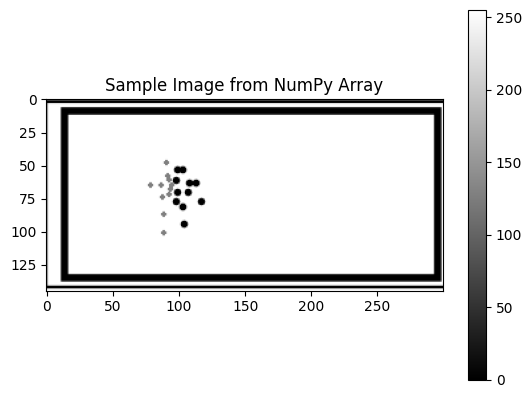

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample NumPy array representing an image
# For example, a grayscale image of size 10x10
image = np.random.rand(10, 10)

# Plot the image
plt.imshow(weekly_data[0][0][0], cmap='gray')  # 'cmap' specifies the color map
plt.colorbar()  # Optional: show the color scale
plt.title('Sample Image from NumPy Array')
plt.show()
